In [1]:
# --- Install required packages (safe to run multiple times) ---
%pip install -q numpy pandas scikit-learn matplotlib joblib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import joblib

# --- Reproducibility ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Matplotlib inline for notebooks ---
%matplotlib inline


In [3]:
# --- Load Iris dataset into a pandas DataFrame ---
iris = load_iris(as_frame=True)
df = iris.frame.copy()  # includes features + target
df.rename(columns={"target": "label"}, inplace=True)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nClass names:", list(iris.target_names))
df.head()


Shape: (150, 5)

Columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'label']

Class names: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
# --- Basic EDA ---
print("Summary statistics for features:")
display(df.drop(columns=["label"]).describe())

print("\nClass distribution:")
print(df["label"].value_counts().sort_index().rename(index=dict(enumerate(iris.target_names))))


Summary statistics for features:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000



Class distribution:
label
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


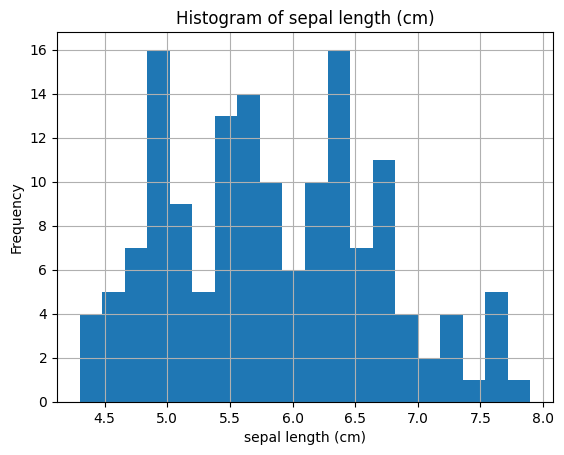

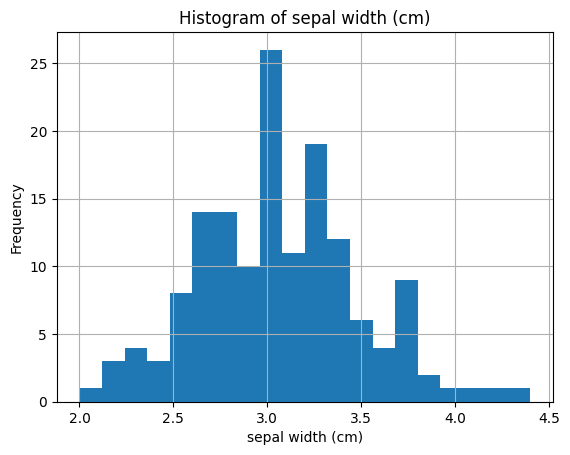

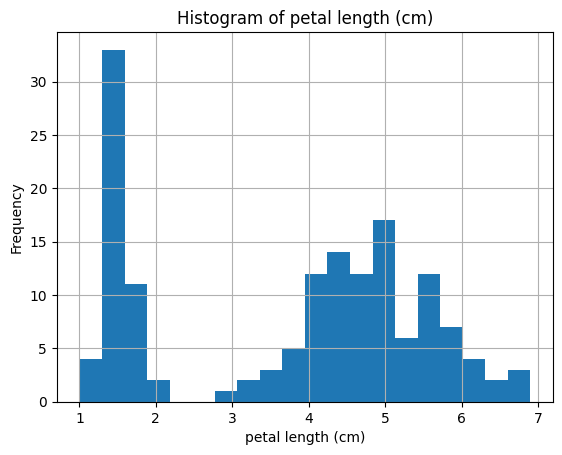

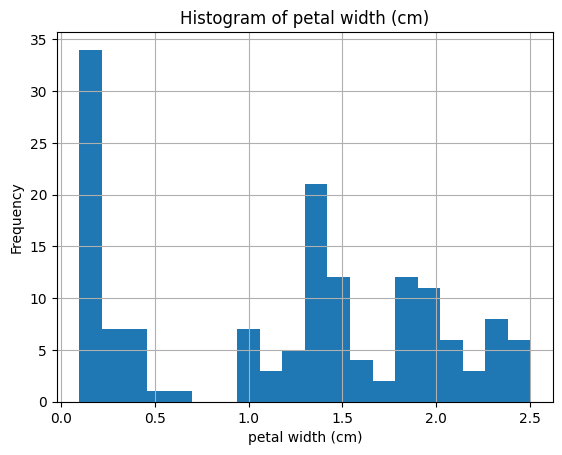

In [5]:
# --- Histograms for each numeric feature ---
features = iris.feature_names
for col in features:
    plt.figure()
    df[col].hist(bins=20)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()


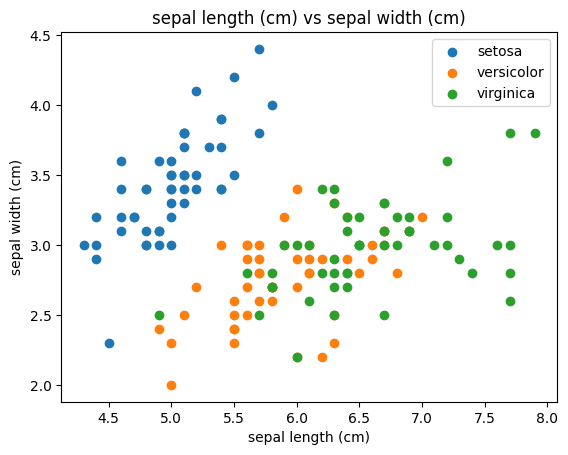

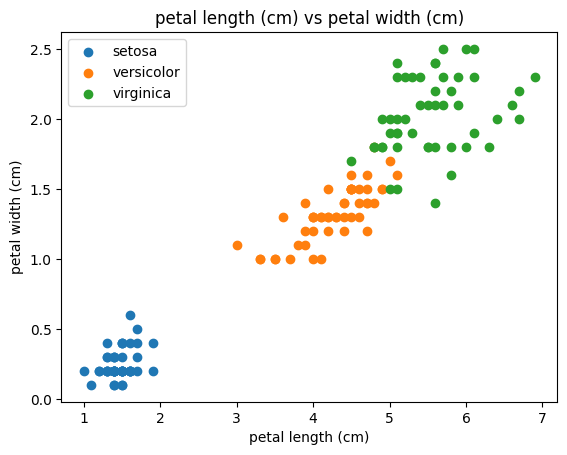

In [6]:
# --- 2D scatter plots by class (no explicit colors) ---
pairs = [("sepal length (cm)", "sepal width (cm)"),
         ("petal length (cm)", "petal width (cm)")]

for x_col, y_col in pairs:
    plt.figure()
    for cls_idx, cls_name in enumerate(iris.target_names):
        subset = df[df["label"] == cls_idx]
        plt.scatter(subset[x_col], subset[y_col], label=cls_name)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"{x_col} vs {y_col}")
    plt.legend()
    plt.show()


In [7]:
# --- Train/Test split ---
X = df[iris.feature_names].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

X_train.shape, X_test.shape


((112, 4), (38, 4))

In [8]:
# --- Train a RandomForestClassifier ---
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Training accuracy (for reference)
train_pred = rf.predict(X_train)
print("Train Accuracy:", accuracy_score(y_train, train_pred))


Train Accuracy: 1.0


Test Accuracy: 0.8947368421052632

Classification Report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        12
  versicolor       0.80      0.92      0.86        13
   virginica       0.91      0.77      0.83        13

    accuracy                           0.89        38
   macro avg       0.90      0.90      0.90        38
weighted avg       0.90      0.89      0.89        38



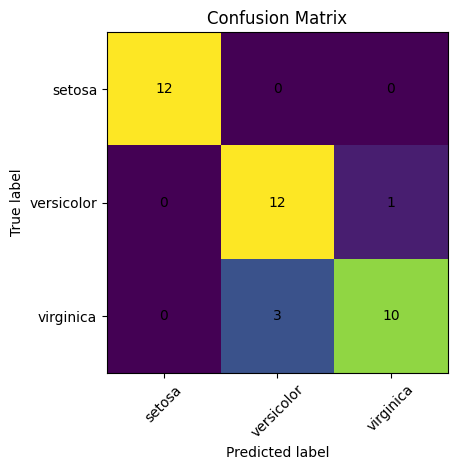

In [9]:
# --- Evaluation on test set ---
y_pred = rf.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=iris.target_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks(ticks=range(len(iris.target_names)), labels=iris.target_names, rotation=45)
plt.yticks(ticks=range(len(iris.target_names)), labels=iris.target_names)
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.show()


In [10]:
# --- Cross-validation (Stratified 5-Fold) ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
print("CV Scores:", cv_scores)
print("CV Mean:", cv_scores.mean(), "  CV Std:", cv_scores.std())


CV Scores: [1.         0.96666667 0.93333333 1.         0.9       ]
CV Mean: 0.9600000000000002   CV Std: 0.038873012632301994


petal length (cm)    0.455831
petal width (cm)     0.406808
sepal length (cm)    0.112132
sepal width (cm)     0.025229
dtype: float64


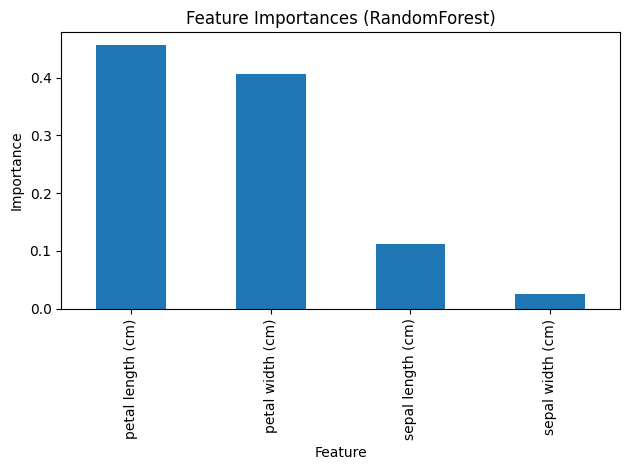

In [11]:
# --- Feature Importances ---
importances = pd.Series(rf.feature_importances_, index=iris.feature_names).sort_values(ascending=False)
print(importances)

plt.figure()
importances.plot(kind="bar")
plt.title("Feature Importances (RandomForest)")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


In [12]:
# --- Save trained model & run example inference ---
model_path = "assignment2_model.joblib"
joblib.dump(rf, model_path)
print(f"Saved model to: {model_path}")

# Example: predict a single sample (first test row)
sample = X_test[0].reshape(1, -1)
pred_label = rf.predict(sample)[0]
print("Sample features:", sample)
print("Predicted class index:", pred_label, "->", iris.target_names[pred_label])


Saved model to: assignment2_model.joblib
Sample features: [[4.4 3.2 1.3 0.2]]
Predicted class index: 0 -> setosa


In [13]:
# --- Utility function for custom predictions ---
def predict_iris(sepal_length, sepal_width, petal_length, petal_width, model=rf):
    x = np.array([[sepal_length, sepal_width, petal_length, petal_width]])
    idx = model.predict(x)[0]
    return iris.target_names[idx]

# Quick test
print("Predict(5.1, 3.5, 1.4, 0.2) ->", predict_iris(5.1, 3.5, 1.4, 0.2))


Predict(5.1, 3.5, 1.4, 0.2) -> setosa
